# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to find the optimal location for a supermarket. This report will be of interest to food retailers for opening new supermarkets in Moscow.
Since there are a huge number of supermarkets in Moscow, we will try to find out from the existing offers for renting out real estate, those where opening a store is optimal.
First of all, we are interested in offers, near which, where the placement of supermarkets nearby is minimal.
We will also choose from offers where the rental rate does not exceed the median.
We will use our data science capabilities to select a few of the most promising proposals based on these criteria, so that stakeholders can choose the best possible end location.

## Data <a name="data"></a>

Based on the definition of our problem, the factors that will influence our decision are:
the number of existing supermarkets in the neighborhood
the number and distance to the supermarkets in the neighborhood
Our research uses the following data sources:
- data on rental offers for premises with an area of 260 to 500 square meters located on the 1st floor of buildings. 

Link 

https://www.cian.ru/cat.php?building_class_type%5B0%5D=1&building_class_type%5B1%5D=2&building_class_type%5B2%5D=3&building_class_type%5B3%5D=4&building_class_type%5B4%5D=8&condition_type_f%5B0%5D=2&condition_type_f%5B1%5D=5&condition_type_f%5B2%5D=6&contract%5B0%5D=1&deal_type=rent&engine_version=2&is_first_floor=1&m2=1&maxarea=500&minarea=260&offer_type=offices&office_type%5B0%5D=2&office_type%5B1%5D=5&office_type%5B2%5D=11&placement_type%5B0%5D=2&region=1&zerocom=0 
- the number of supermarkets, their location in each area will be obtained using the Foursquare API

In [1]:
#!pip install yandex-geocoder
#!pip install geopy

In [2]:
import pandas as pd
from yandex_geocoder import Client
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import folium
import requests
import urllib
import seaborn as sns

In [3]:
CLIENT_ID = 'XXXX' # set your credentials
CLIENT_SECRET = 'XXX' # set your credentials

Offers:
https://www.cian.ru/cat.php?building_class_type%5B0%5D=1&building_class_type%5B1%5D=2&building_class_type%5B2%5D=3&building_class_type%5B3%5D=4&building_class_type%5B4%5D=8&condition_type_f%5B0%5D=2&condition_type_f%5B1%5D=5&condition_type_f%5B2%5D=6&contract%5B0%5D=1&deal_type=rent&engine_version=2&is_first_floor=1&m2=1&maxarea=500&minarea=260&offer_type=offices&office_type%5B0%5D=2&office_type%5B1%5D=5&office_type%5B2%5D=11&placement_type%5B0%5D=2&region=1&zerocom=0

### Import rental offers from cian.ru and clear data

In [4]:
df = pd.read_excel('offers.xlsx', index_col = 0)
df = df[['Площадь', 'Класс', 'Метро', 'Адрес',  'Цена']]
df['Цена'] = df['Цена'].apply(lambda x: x[:x.find(' ')]).astype(float)
df['Площадь'] = df['Площадь'].apply(lambda x: x[:x.find(',')]).astype(float)
df['цена/квм'] = df['Цена'] / df['Площадь']
df.columns = ['square', 'class', 'metro', 'address', 'price', 'price/sqm']
df.head()

,square,class,metro,address,price,price/sqm
ID объявления,,,,,,
236265804,300.05,B+,м. Сухаревская (8 мин пешком),"Москва, Большая Сухаревская площадь, 9",500084.0,1666.668889
179212286,1000.00,B,м. Селигерская (7 мин пешком),"Москва, Дмитровское шоссе, 81, ш. Алтуфьевское...",1500000.0,1500.000000
240256876,290.60,B+,м. Автозаводская (7 мин пешком),"Москва, улица Ленинская Слобода, 26",789464.0,2716.668961
245425079,338.00,B+,м. Шоссе Энтузиастов (13 мин пешком),"Москва, шоссе Энтузиастов, 34",281667.0,833.334320
227825542,374.00,B,м. Спортивная (15 мин пешком),"Москва, Большой Саввинский переулок, 12С8",779167.0,2083.334225


In [5]:
df.dtypes

square       float64
class         object
metro         object
address       object
price        float64
price/sqm    float64
dtype: object

### Getting the coordinates for the addresses

In [6]:
client = Client("54236946-3577-44b3-a4d0-d3598e4c3690")
df['coordinates'] = df['address'].apply(lambda x: client.coordinates(x))
df.head()

,square,class,metro,address,price,price/sqm,coordinates
ID объявления,,,,,,,
236265804,300.05,B+,м. Сухаревская (8 мин пешком),"Москва, Большая Сухаревская площадь, 9",500084.0,1666.668889,"(37.63835, 55.772436)"
179212286,1000.00,B,м. Селигерская (7 мин пешком),"Москва, Дмитровское шоссе, 81, ш. Алтуфьевское...",1500000.0,1500.000000,"(37.549812, 55.86155)"
240256876,290.60,B+,м. Автозаводская (7 мин пешком),"Москва, улица Ленинская Слобода, 26",789464.0,2716.668961,"(37.654601, 55.710124)"
245425079,338.00,B+,м. Шоссе Энтузиастов (13 мин пешком),"Москва, шоссе Энтузиастов, 34",281667.0,833.334320,"(37.735063, 55.754127)"
227825542,374.00,B,м. Спортивная (15 мин пешком),"Москва, Большой Саввинский переулок, 12С8",779167.0,2083.334225,"(37.562344, 55.732692)"


### Displaying all offers on the map

In [7]:
def create_map_offers(df, markets = None):
    m = folium.Map(location=[55.755969, 37.617685], zoom_start=10)
    for i in df.index:
        tmp = df[df.index == i]
        lon, lat = tmp['coordinates'].values[0]
        if 'offer_id' in df.columns:
            i = tmp['offer_id'].values[0]
        folium.Marker(
            location=[float(lat), float(lon)],
            popup= 'id: ' + str(i) + '<div>square: ' + str(tmp['square'].values[0]) + '<div>price/sqm: ' + 
            str(round(tmp['price/sqm'].values[0], 2)),
            icon=folium.Icon()
        ).add_to(m)
    if markets is None:
        return m
    if 'offer_id' in df.columns:
        markets = df.merge(markets, how = 'inner', on = 'offer_id')
    else:
        markets = df.merge(markets, how = 'inner', left_on = df.index, right_on = 'offer_id',)
    for i in markets.index:
        tmp = markets[markets.index == i]
        folium.CircleMarker(
            location=[tmp['lat'].values[0], tmp['lng'].values[0]],
            popup= tmp['name'].values[0] + 
                            '<div>distance: ' + str(tmp['distance'].values[0]),
            radius=5,
            color="yellow",
            fill=True,
            fill_color="#3186cc",
        ).add_to(m)
    m.save('test.html')
    return m

In [8]:
create_map_offers(df)

# Foursquare
Now that we have our location candidates, let's use the Foursquare API to get information about the supermarket in each neighborhood.

We are interested in establishments of the supermarket category. We are not interested in establishments of a different format for the sale of food.

Categories are taken from the link https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [9]:
def get_venues(lat, lon, radius=1000, limit=100):
    category = '52f2ab2ebcbc57f1066b8b46' # supermarker
    VERSION = '202100304'
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'\
            .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, limit)
    results = requests.get(url).json()
    venues = pd.DataFrame(results['response']['venues'])
    if len(venues) == 0:
        return 
    supermarket = pd.DataFrame()
    for i in venues['location'].values:
        supermarket = supermarket.append(i, ignore_index=True)
    supermarket = supermarket[['city', 'address', 'lat', 'lng', 'distance']]
    supermarket['id'] = venues['id']
    supermarket['name'] = venues['name']
    return supermarket

### Getting supermarkets within 1 km of the rental offer

In [10]:
supermarkets = pd.DataFrame()
for i, row in df.iterrows():
    lon, lat = row[6]
    tmp = get_venues(float(lat), float(lon))
    if tmp is not None:
        tmp.sort_values('distance', inplace = True)
        tmp['offer_id'] = i
        supermarkets = supermarkets.append(tmp, ignore_index = True)
supermarkets.head()

,city,address,lat,lng,distance,id,name,offer_id
0,Москва,Anan'yevskiy pereulok,55.771574,37.637056,125.0,57ee997e498e15fd34fcfa6c,Густо,236265804
1,NaN,"Ананьевский пер., 4/2, стр.3",55.770285,37.636602,263.0,4e6795297d8b084ac763e474,Магнолия,236265804
2,Москва,"Большая Спасская ул., 27",55.775981,37.642410,469.0,5971d9e535811b1c18cfac70,EuroSpar,236265804
3,Москва,"ул. Маши Порываевой, 34",55.772357,37.647286,559.0,4fed8f04e4b066037194d678,Мираторг,236265804
4,Москва,Большая Спасская 33,55.776280,37.645600,623.0,4c34574c7cc0c9b6811ff39a,Магнолия,236265804


Now we have all the supermarkets in the immediate vicinity of every rental offer.

This completes the data collection stage - we are now ready to use this data for analysis to prepare a report on the optimal locations for the new supermarket

## Methodology <a name="methodology"></a>

In this project, we will focus our efforts on identifying areas of Moscow with a low density of supermarkets, especially those where there are few of them.

- At the first stage, we collected the necessary data from the database of real estate rental offers

- The second step in our analysis will be to calculate and study the density of supermarkets within a 1 km radius of the potential location and identify several promising areas with a low number of supermarkets and focus our attention on these areas.

- At the third and final stage we will focus on the most promising areas that meet some basic requirements: we will consider locations with no supermarkets at a distance of 100 meters, the number of supermarkets not exceeding 1 quantile of the average number of supermarkets for a sample of about 200 premises offered for rent.

## Analysis <a name="analysis"></a>

First, let's count the number of supermarkets in each candidate area:

In [32]:
min_dist = supermarkets.groupby(['offer_id'])['distance'].min().reset_index()
min_dist.columns = ['offer_id', 'min_distance']
df_union = df.merge(min_dist, how = 'left', left_on = df.index, right_on = 'offer_id' ).sort_values('min_distance')

### You can see which networks represent the main supermarkets

In [33]:
networks = supermarkets[['id', 'name']]
networks = networks.drop_duplicates()
networks['name'] = networks['name'].apply(lambda x: x.replace('ё', 'е').strip())
networks_group = networks.groupby('name').count()['id'].reset_index().sort_values('id', ascending = False)
networks_group.columns = ['name', 'count']
networks_group.head()

,name,count
82,Пятерочка,166
57,Магнолия,120
73,Перекресток,85
54,Магнит,66
1,BILLA,26


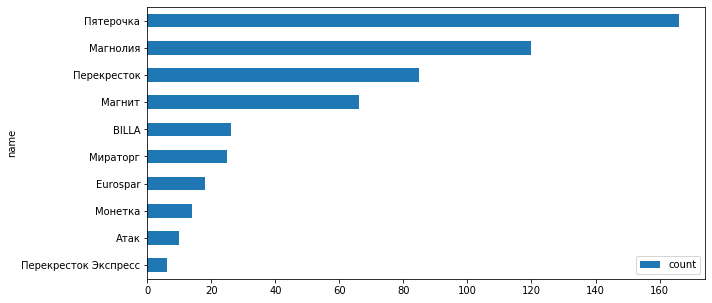

In [34]:
networks_group.head(10).set_index('name').sort_values('count').plot(kind = 'barh', figsize = (10,5))

But since it is not a task to open a supermarket of a particular network, this data will not be used for filtering

### Distribution of the average number of supermarkets

In [35]:
count_super = supermarkets.groupby(['offer_id'])['distance'].count().reset_index()
count_super.columns = ['offer_id', 'count']

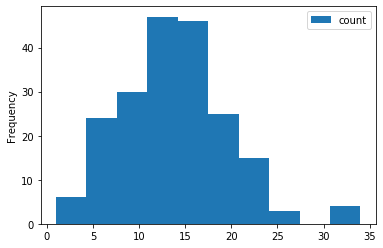

In [36]:
count_super.drop('offer_id', axis = 1).plot(kind = 'hist')

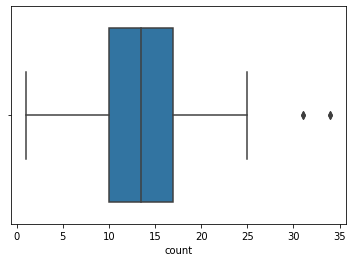

In [37]:
sns.boxplot(count_super['count'])

In [38]:
count_super['count'].median()

13.5

The median number of supermarkets for each of the offers is 13.5. Since the number of supermarkets is large, some of them may be located in the same buildings. These options for rental offers must be filtered out

In [39]:
df_union = df.merge(min_dist, how = 'left', left_on = df.index, right_on = 'offer_id' )
df_union = df_union.merge(count_super, how = 'left', on = 'offer_id')

**Filter** these locations: we are only interested in **locations with no supermarkets within a radius of 100 meters**

In [40]:
df_filter = df_union[(df_union['min_distance'] > 100) | df_union['min_distance'].isnull()]

### We filter rental offers that are outside of 1 quantile

In [41]:
q1 = count_super['count'].quantile(0.25)
df_filter = df_filter[(df_filter['count'] < q1) | (df_filter['count'].isnull())]

### Distribution by rental price per square meter

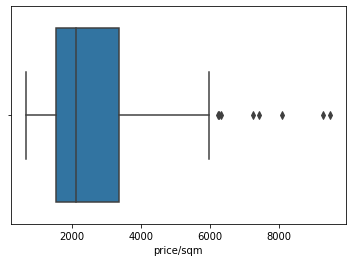

In [42]:
sns.boxplot(df['price/sqm'])

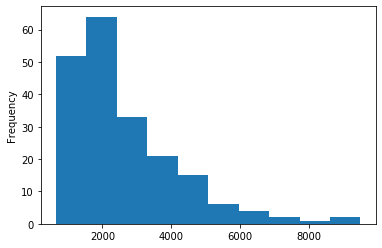

In [43]:
df['price/sqm'].plot(kind = 'hist')

### Remove offers with a value exceeding median price

In [44]:
result = df_filter[df_filter['price/sqm'] <= df['price/sqm'].median()]

In [45]:
len(result)

26

### Сreating a map with rental offers and existing supermarkets

In [47]:
create_map_offers(result, supermarkets)

This concludes our analysis. We have created **26** addresses containing places with a small number of supermarkets, no other supermarkets within a 100 m radius. 
The location of supermarkets is very irregular, and their centers/addresses should only be considered as a starting point for exploring the surrounding area in search of potential locations for a new supermarket.

## Results and Discussion <a name="results"></a>

Our analysis shows a huge number of supermarkets in Moscow, but there are pockets of low supermarket density. The result of all this is **26** potential offers for new supermarkets depending on the number and distance to existing sites . This, of course, does not mean that these areas are actually the optimal places for a new supermarket. The purpose of this analysis was to provide information for further consideration of suitable proposals. Therefore, the recommended zones should only be considered as a starting point for a more detailed analysis, which may eventually lead to a location where not only there will be no competition nearby, but other factors will be taken into account and all other relevant conditions will be met.

## Conclusion <a name="conclusion"></a>

The goal of this project was to identify areas with a small number of supermarkets within Moscow's borders to help stakeholders narrow down the search for the optimal location for opening a new supermarket. By calculating the distribution of supermarket densities based on Foursquare data, we have created a collection of locations that meet some of the basic requirements for existing nearby supermarkets. 
The final decision on the optimal location of the restaurant will be made by the stakeholders based on the specific characteristics of the facilities